# Project Youth Talk 1
## Find open forms topics from empathy categories questionnaires by Cyril Vincent
I used different statistic, machine leanrning and LLM models, this document explain the process
## 1. Database
I create a SQL database from the data collected, using PostgreSql.  
### 1.1 Diagram
See the database diagram :  
![sql](doc/uml.png)
### 1.2 Form
A **form** is a response by a user to the form.  
Example of SQL: 


In [1]:
import jupyter_service
from dbcontext import Context
context = Context()
context.create(echo=False)
service = jupyter_service.JupyterService(context)
df = service.get_by_sql("select * from form limit 5")
df

,id,participant_name,country,situation,yob,gender,education,parents_education,income_scale,most_identification,...,empathy_f_23,empathy_pd_24,empathy_pt_25,empathy_f_26,empathy_pd_27,empathy_pt_28,empathy_answers,total_answers,date_added,date_computed
0,252,Participant-252,ESP / Spain,None,None,None,None,None,None,Being a part of the world,...,NaN,NaN,NaN,NaN,NaN,NaN,0,6,2024-10-25 10:04:29.018920,None
1,253,Participant-253,IND / India,I am studying,2008,Male,Primary education,Upper secondary education (high school),8,Being a part of the world,...,5.0,5.0,5.0,5.0,5.0,5.0,15,30,2024-10-25 10:04:29.018920,None
2,254,Participant-254,USA / United States of America (the),I am studying,2005,Female,Primary education,Master's or equivalent,7,Being a part of this country,...,NaN,NaN,NaN,NaN,NaN,NaN,0,19,2024-10-25 10:04:29.018920,None
3,257,Participant-257,PRT / Portugal,None,None,None,None,None,None,Being a part of this country,...,NaN,NaN,NaN,NaN,NaN,NaN,0,2,2024-10-25 10:04:29.018920,None
4,258,Participant-258,None,None,None,None,None,None,None,Being part of the city or area where you live,...,NaN,NaN,NaN,NaN,NaN,NaN,0,2,2024-10-25 10:04:29.018920,None


## 2. Feature extraction by Textrank
### 2.1. Textrank
I first used the statistical language model **Textrank** to do the feature extraction.  
Textrank is an automatic keyword and sentence extraction (summarization) as done in [this document](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf). However, this implementation uses Levenshtein Distance as the relation between text units.  
I extract a maximum of 3 keywords by form.  
I only process the question 1 and 2.  
Example:

In [2]:
from textrank_model import TextrankModel
shakespear = "Let me not to the marriage of true minds. Admit impediments. Love is not love. Which alters when it alteration finds. Or bends with the remover to remove. O no! it is an ever-fixed mark wedding"
m = TextrankModel()
res = m.tokenize_textrank(shakespear)
res

C:\Users\conta\git-CVC\Skema\git-youth_talk\youth_talk_1\.venv\Lib\site-packages


[[minds 0], [impediments 0], [love 0, love 0]]

### 2.2. Normalize
After I normalize all words to lowercase and count its.  
Exeample :

In [3]:
dico = m.count(res)
dico

{'minds': minds 1, 'impediments': impediments 1, 'love': love 2}

## 3. Grouping features by NLTK
### 3.1. NLTK
NLTK (Natural Language Toolkit) is a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries, and an active discussion forum.
[see NLTK.org](nltk.org).  
I used NLTK for searching synonyms.  
Example :

In [4]:
res = m.get_synonyms("wedding")
res

['wedding',
 'wedding_ceremony',
 'nuptials',
 'hymeneals',
 'marriage',
 'marriage_ceremony',
 'wedding_party',
 'marry',
 'get_married',
 'conjoin',
 'hook_up_with',
 'get_hitched_with',
 'espouse',
 'splice']

### 3.2 Grouping
After I group all the same keywords into a **topic**. A topic is a word or a couple of word.
Example: 

In [5]:
res = m.tokenize(shakespear)
print(f"Try to grouping all these words")
dico = m.count(res)
print(dico)
topics = m.grouping(dico, "textrank")
for topic in topics:
    print(f"Topic {topic.label}")

Try to grouping all these words
{'marriage': marriage 1, 'minds': minds 1, 'admit': admit 1, 'impediments': impediments 1, 'love': love 2, 'alters': alters 1, 'alteration': alteration 1, 'finds': finds 1, 'bends': bends 1, 'remover': remover 1, 'remove': remove 1, 'fixed': fixed 1, 'mark': mark 1, 'wedding': wedding 1}
Topic marriage
Topic minds
Topic admit
Topic impediments
Topic love
Topic alters
Topic alteration
Topic finds
Topic bends
Topic remover
Topic mark


### 3.3 Lemas
Each topic a linked to several **lemas** and several forms.  
A lema is a keyword synonym linked to a topic.  
Example :

In [6]:
print(f"Topic {topics[0].label} has several lemas:")
[lema.label for lema in topics[0].lemas]

Topic marriage has several lemas:


['marriage', 'wedding', 'mark_wedding']

### 3.4 Gestalt
I used the model **Gestalt pattern matching** algorithm mesure the syntaxic distance beetween to sentences. [See Gestalt](https://en.wikipedia.org/wiki/Gestalt_pattern_matching).  
Gestalt find for me the syntaxic errors or words with the same suffix or prefix.
For example if I add the term "weding" with one "d":


In [7]:
res = m.tokenize(shakespear + " mariage")
dico = m.count(res)
topics = m.grouping(dico, "textrank")
print(f"Topic {topics[0].label} has several lemas:")
[lema.label for lema in topics[0].lemas]

Topic marriage has several lemas:


['marriage', 'wedding', 'mark_wedding', 'mariage', 'wedding_mariage']

### 3.5. Word Cloud
I used a word cloud to display differents lemas.  
Example :

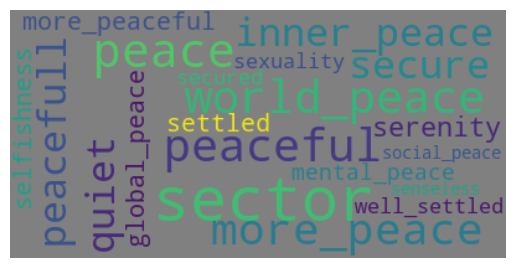

In [8]:
df = service.get_lemas("peace", "textrank")
service.show_lemas(df)

## 4. Scoring empathy categories
We have 4 empathy categories : 
* empathic concern (ec)
* perspective taking (pt)
* fantasy (f)
* personal distress (pd)

Each category have 3 scores (1 to 5) with 1 inversed score.
I calculate the mean of scores for each categries and I create 3 levels of categories :
* negative (0)
* neutral (1)
* positive (2)
So I have 12 scores named ec0 to pd2.
Example :  

In [9]:
df = service.get_by_sql("select * from stat limit 5")
df

,id,pd_score,pd_category,ec_score,ec_category,pt_score,pt_category,f_score,f_category,empathy_score,empathy_category,q1_2_nb_word,q1_2_sentiment,q3_4_nb_word,q3_4_sentiment,date,textrank_date,td_idf_date,openai_date,nltk_date
0,678,2.25,0.0,3.666667,1,4.75,2.0,2.50,1,3.291667,1,7,0.0000,7,-0.4215,2024-11-03 21:16:31.457239,2024-11-05 15:28:36.176252,2024-11-05 23:23:49.512894,2024-11-07 13:09:14.632287,2024-11-05 16:26:35.967012
1,2552,3.50,1.0,2.666667,1,2.75,1.0,2.25,0,2.791667,1,3,0.0000,2,0.0000,2024-11-03 21:16:31.459301,2024-11-05 15:28:36.459410,2024-11-05 23:23:49.677780,2024-11-07 13:09:21.480614,2024-11-05 16:26:36.281758
2,728,NaN,NaN,4.000000,2,NaN,NaN,4.00,2,4.000000,2,8,0.5423,5,0.0000,2024-11-03 21:16:31.460309,2024-11-05 15:28:36.524191,2024-11-05 23:23:49.747340,2024-11-07 13:09:22.085216,2024-11-05 16:26:36.343040
3,729,3.25,1.0,3.000000,1,4.50,2.0,2.50,1,3.312500,1,12,0.5267,4,-0.6249,2024-11-03 21:16:31.460309,2024-11-05 15:28:36.529324,2024-11-05 23:23:44.671700,2024-11-07 13:09:22.085216,2024-11-05 16:26:36.346915
4,911,3.25,1.0,4.333333,2,3.75,2.0,2.25,0,3.395833,1,7,0.5423,7,-0.8271,2024-11-03 21:16:31.471452,2024-11-05 15:28:37.575055,2024-11-05 23:23:50.370125,2024-11-07 13:09:50.114987,2024-11-05 16:26:37.252574


## 5. Count topics
Every topic is counted by used form
Exemple :

In [10]:
df = service.get_topics("textrank", 12)
df.head(5)

,topic,nb_form
0,peace,2898
1,world,2039
2,countries,2026
3,life,1702
4,good,1517


## 6. Scoring
### 6.1. Score most cited topics
I count for each empathy score the number of form which used a topic.  
Example for positive pd (pd0):  

In [20]:
empathy_category="pd"
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
df = service.get_scores("textrank", 12, empathy_category, positive=True, denominator_thresold=0, numerator_thresold=0, debug=False)
df = df.sort_values(by=["nb_positive_form"], ascending=False)
df.head(5)

,id,topic,nb_positive_form,nb_negative_form,score
542,5980,peace,746,647.00,1.15
517,5998,world,549,435.00,1.26
696,5955,countries,484,513.00,0.94
565,5960,life,416,393.00,1.06
686,6021,good,365,367.00,0.99


### 6.2. Score discriminant topics
I count for each empathy score the number of form which used a topic.  
Then I calculate a ratio, for example: 
```
pd2_ratio = nb_positive_form / nb_negative_form
pd0_ratio = nb_negative_form / np_negative_form
```

Example for negative pd (pd0):  

In [12]:
empathy_category="pd"
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
df = service.get_scores("textrank", 12, empathy_category, positive=False, denominator_thresold=0, numerator_thresold=57, debug=False)
df.head(5)

,id,topic,nb_negative_form,nb_positive_form,score
0,6338,economic,63,24,2.62
1,6182,security,87,54,1.61
2,6120,stability,120,75,1.60
3,5975,balance,69,49,1.41
4,6074,ability,59,42,1.40


## 7. TdIdf
I used the TdIdf model but the result is not probative

## 8. LLM
I used OpenAI ChatGPT to extract topics for each form.  
I used the gpt-4o model. 
Then I score each topics like previously.
I do prompt engineering to optimize the responses.  
I searched synonyms lemas with NLTK like previously.  
Then I demand to ChatGPT to explain the topic.  
Example for pd2:

In [13]:
pd.set_option('max_colwidth', 1000)
df = service.get_scores("gpt-4o-mini", 12, "pd", positive=True, denominator_thresold=0, numerator_thresold=50, gpt_comment=True)
df.head(5)

,id,topic,nb_positive_form,nb_negative_form,score,explaination
0,30737,wish,62,33,1.88,"Personal distress can inspire positive wishes, fostering hope, improvement, happiness, and a desire for a better world."
1,30740,world,187,105,1.78,"Fostering happiness, peace, sustainability, education, kindness, and cooperation creates a promising future for individuals and the world."
2,30792,rich,54,34,1.59,"Positive terms related to personal distress and richness include happiness, peace, health, security, kindness, equality, sustainability, and harmony."
3,30816,dreams,58,37,1.57,"Hope, fulfillment, aspirations, happiness, peace, equality, success, kindness, awareness, empowerment, dreams realized, opportunity, collaboration, compassion."
4,30857,kindness,64,41,1.56,"kindness, compassion, acceptance, happiness, tolerance, peace, empathy, success, community, fulfillment, resilience, love, unity, generosity, balance, self-acceptance, growth, support, joy, inspiration."


## 9. Reinforcement
### 9.1. prediction too scattered  
Unlike NLTK, chatgpt makes predictions that are too dispersed without using the sysnonym.  
For example, if a text talks about wedding it will predict wedding as topic but if the text uses the the synonym marriage it will predict marriage.  
I was not able to correct this problem through prompt engineering. As it stands ChatGpt was therefore no better than Textrank and NLTK.  

### 9.2. Reinforcment
I therefore undertook to choose the 50 best topics of each category (i.e. 400 topics) with their NLTK synonyms (lemas), then to reinject them into ChatGPT by explaining to it to use topics instead of lemas.  
I reinforced all qualified data (forms with a score) in ChatGPT.  
Then a reiterates the process.  

### 9.3. Fine Tuning
I tried to do a fine tuning, but it is not appropried for this training because we want to predict topics from discrete values and not the inverse. 

### 9.4. Main topics and probabilities
I reiterates the prompt enginnering to have more convenient topics.    
I refactored the code which now indicates the probability of the relevance of the topic for the selected empathy category.  
I then hierarchized the topics with a main topic which can be linked to several topics which are themselves linked to lemas.   
Example for ec0 :


In [14]:
df = service.get_highlevel_linked(12, "ec", False)
df = df.drop(["topic0_id", "topic1_id", "topic2_id"], axis=1)
df.head(5)

,id,main_topic,score,topic1,topic2,explaination
0,16,war,0.90,war,None,"Empathic concern may lead to selective compassion, promoting bias, justification of violence, and perpetuation of conflict in war contexts."
1,17,global warming,0.85,global,warming,"Empathic concern may lead to anxiety, helplessness, or apathy regarding global warming's overwhelming nature and complexity."
2,19,inequality,0.85,inequality,None,"Empathic concern can lead to favoritism, neglecting broader inequalities, and fostering dependency rather than empowerment in relationships."
3,14,depression,0.80,depression,None,"Empathic concern can lead to emotional exhaustion, compassion fatigue, and may exacerbate feelings of hopelessness in depression."
4,18,poverty,0.80,poverty,None,"Negative terms include compassion fatigue, emotional burnout, apathy, and societal desensitization towards poverty-related issues and suffering."


## 10. GPT Low Noise
We want to detect topic with low noise.
The reinforcment learning does not work for the low noise, because I reinforce only the main topics.  
I tried to reinforce all topcis, but it does not work for low noise.  
So I take the previous GPTModel + NLTK on topics + lemas.  
A topic with low noise is a rare topic but with a big score.  
For example for a negative ec:
```
ec0_low_score = ec0_score / ec2_score
for each number of ec0: 5 < nb_positive_form < mean or median
```
With the GPT model I never found negative topic, beacause questions 1 and 2 are too positives.   
Example for a positive low noise topic ec0:


In [15]:
df = service.get_scores("gpt-4o-mini", 12, "pd", positive=True, denominator_thresold=0, numerator_thresold=5, gpt_comment=True)
df=df[(df.score > 6) & (df.nb_positive_form < 50)] 
df.head(5)

,id,topic,nb_positive_form,nb_negative_form,score,explaination
0,31947,becomebetter,42,NaN,420.00,"Personal distress can lead to growth, empathy, resilience, self-awareness, and improved relationships, fostering overall well-being and strength."
1,31948,numerous,42,NaN,420.00,"Resilience, growth, support, empathy, self-awareness, healing, empowerment, compassion, adaptation, transformation, connection, perseverance."
2,30882,billionaire,9,NaN,90.00,"Aspiring billionaires seek to create positive change, support communities, invest in sustainability, and foster professional success and happiness."
3,30981,secure,7,NaN,70.00,"Positive terms: happiness, security, freedom, peace, independence, acceptance, health, sustainability, financial stability, joy, success, community."
4,30946,succes,6,NaN,60.00,"Personal distress can lead to growth, while success brings happiness, peace, stability, equality, and opportunities for all."


## 11. Vader
VADER Sentiment Analysis.  
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains. [See on github](https://github.com/cjhutto/vaderSentiment).   
We can calculate sentiment of a sentence.  
Example: 

In [16]:
sentences = ["The service here is extremely good", "The service here is extremely bad", "The service correct"]
for s in sentences:
    print(f"{s} => sentiment_score: {m.sentiment(s):.2f}")

The service here is extremely good => sentiment_score: 0.49
The service here is extremely bad => sentiment_score: -0.58
The service correct => sentiment_score: 0.00


## 12. GPT Low Noise + Vader
I determin a bad sentiment where sentiment_score < 0.33 and a good sentiment where sentiment_score > 0.33 :  
```
good_sentiment = sentiment_score < 0.33
bad_sentiment = sentiment_score > 0.33
```
Bad sentiments for questions 1 and 2 are rare so I changed the formula for the low noise score.  
For example for a negative ec:
```
ec0_low_score = ec0_score and bad_sentiment / ec2_score and good_sentiment
```
Example for a negative low noise topic ec0:

In [17]:
df = service.get_scores("gpt-4o-mini", 12, "pd", positive=False, denominator_thresold=0, numerator_thresold=5, gpt_comment=True, sentiment=False)
df=df[(df.score > 5) & (df.nb_positive_form < 50)] 
df.head(5)

,id,topic,nb_negative_form,nb_positive_form,score,explaination
0,30941,experience,9,1,9.00,"Negative terms related to personal distress include anxiety, frustration, burnout, isolation, dissatisfaction, helplessness, and emotional pain."
1,31056,housing,9,1,9.00,"Negative terms include poverty, homelessness, insecurity, inequality, distress, inadequate housing, financial burden, fear, and instability."
2,31112,economic,19,3,6.33,"Negative terms related to personal distress and economic issues include inequality, exploitation, poverty, instability, injustice, and lack of access."
3,31263,learn,12,2,6.00,"Negative terms related to personal distress include anxiety, depression, isolation, insecurity, frustration, overwhelm, and hopelessness."
4,31466,long,6,1,6.00,"Negative terms related to personal distress and longevity include suffering, fatigue, burden, loneliness, stagnation, and regret."
